In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pycbc.filter.matchedfilter import sigma
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


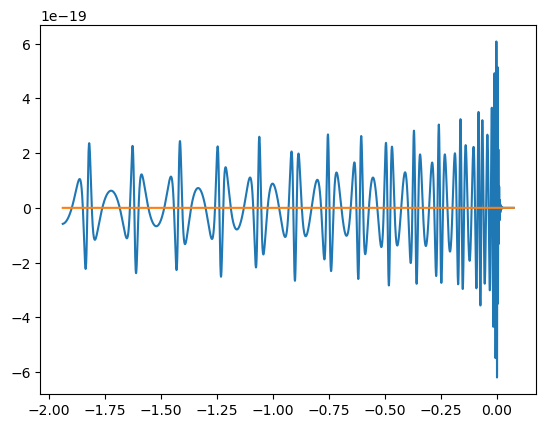

In [28]:
h_0 = gen_wf(10, 0.5, 60, 2, 4096, 'TEOBResumS', inclination=0)
h_pi_2 = gen_wf(10, 0.5, 60, 2, 4096, 'TEOBResumS', inclination=np.pi/2)
h_pi_2.start_time = h_0.start_time

plt.plot(h_0.sample_times, h_0.real())
plt.plot(h_pi_2.sample_times, h_pi_2.real() - h_0.real()/2)
# plt.xlim(-6.5, -5.5)
# plt.ylim(-2e-19, 2e-19)

So far we have been using a lower frequency in all match functions of f_low+3, so virtually always 13 Hz. The problem is that generating harmonics at 10Hz causes h1 to start at (just under) 15 Hz, and h2 at (just under) 20 Hz. This is therefore not quite correct. In reality current detectors struggle to see anything below 20 Hz and so our current psd of aLIGOZeroDetHighPower is somewhat optimistic in this regard. Nevertheless we will calculate the power loss with this psd of increasing the lower frequency cutoff from 13 to 20 Hz.

We will assume effect when calculating harmonics themselves to be negligible and continue using 13Hz there for now until/if we change it globally.

In [2]:
_, h0, h1, hn1, h2, _, _, _, _ = get_h([1,1,1,1], 10, 0.3, chirp2total(24,2), 2, 4096)
psd = gen_psd(h0, 10)
for harm in [h0, h1, hn1, h2]:
    harm_f = harm.real().to_frequencyseries()
    remaining_power = sigma(harm_f, psd, low_frequency_cutoff=20, high_frequency_cutoff=psd.sample_frequencies[-1])
    total_power = sigma(harm_f, psd, low_frequency_cutoff=13, high_frequency_cutoff=psd.sample_frequencies[-1])
    print(f'{(total_power-remaining_power)*100/total_power:.2f}% loss in power')

1.14% loss in power
3.94% loss in power
2.21% loss in power
1.71% loss in power


No matter the choice of eccentricity or chirp mass (or mass ratio), there is never more than about a 5% power loss in any harmonic, and usually less than this. This seems acceptable, and will again be more realistic anyway with regards to how far low in frequency we can actually see.

Now changed globally. By default get_h() etc. will use 20Hz however can also override in (almost) all relevant functions with f_match parameter.

Let's compare the min/max lines with the old f_match of 13 Hz and the new f_match of 20 Hz. Note that the fid e scaling normalisation has also changed from 0.035 at 10 chirp mass to 0.03, as this seems to fit the new f_match better.

In [3]:
# Load old data
with open(os.path.join('grid_data', 'dataslot_30', 'all_matches'), 'rb') as fp:
        grid_data_old = pickle.load(fp)

# Find min and max
chirp = list(grid_data_old.keys())[0]
keys = list(grid_data_old[chirp].keys())
for key in keys:
    if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
        grid_data_old[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data_old[chirp][key]), axis=1)
        grid_data_old[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data_old[chirp][key]), axis=1)

# Load new data
with open(os.path.join('grid_data', 'dataslot_35', 'all_matches'), 'rb') as fp:
        grid_data_new = pickle.load(fp)

# Find min and max
keys = list(grid_data_new[chirp].keys())
for key in keys:
    if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
        grid_data_new[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data_new[chirp][key]), axis=1)
        grid_data_new[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data_new[chirp][key]), axis=1)

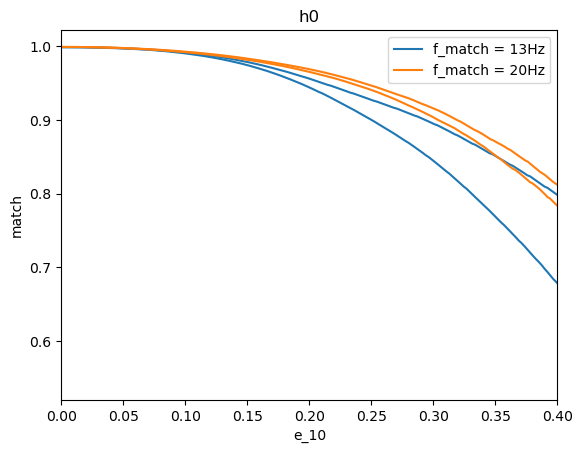

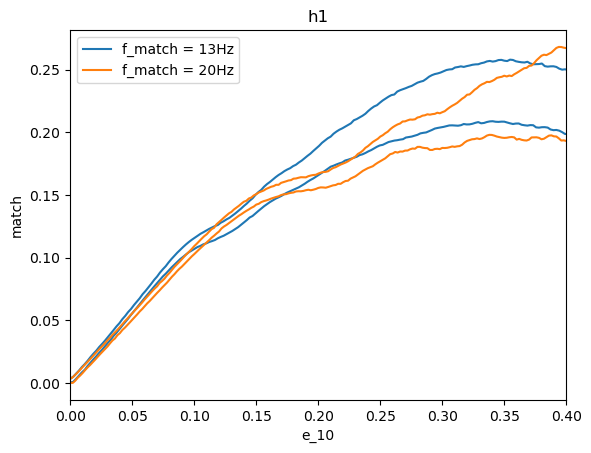

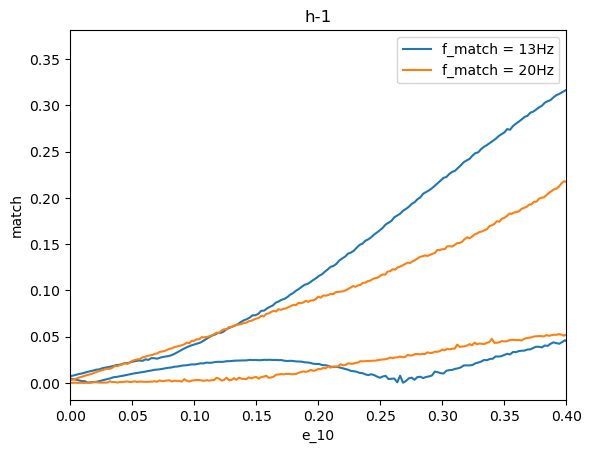

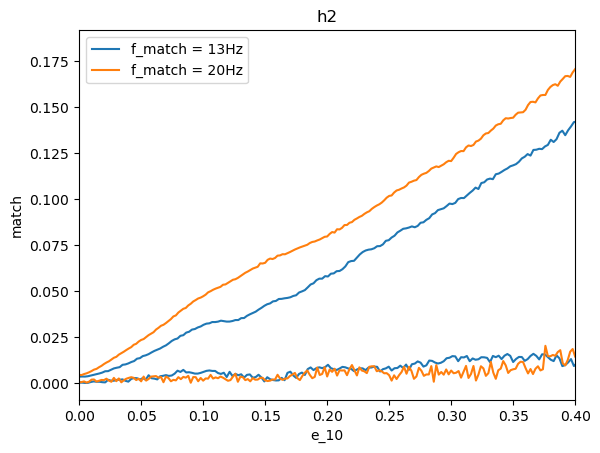

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


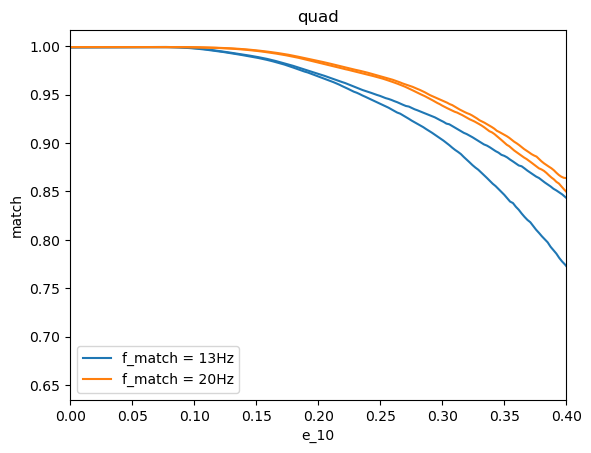

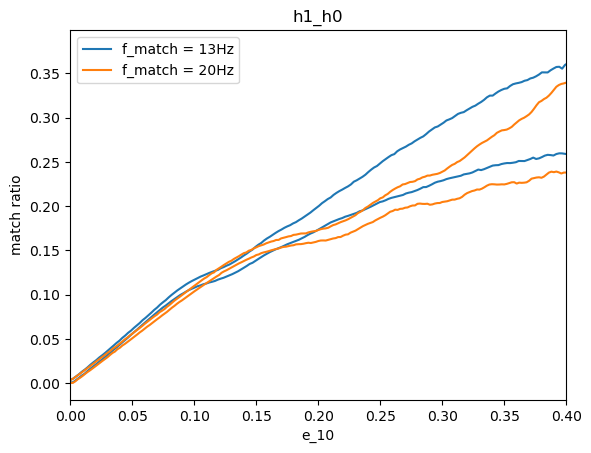

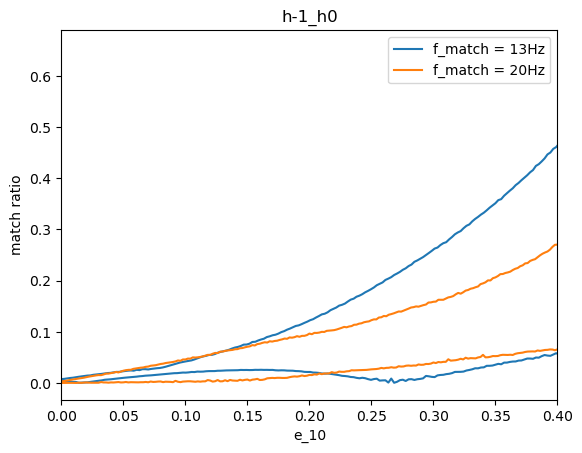

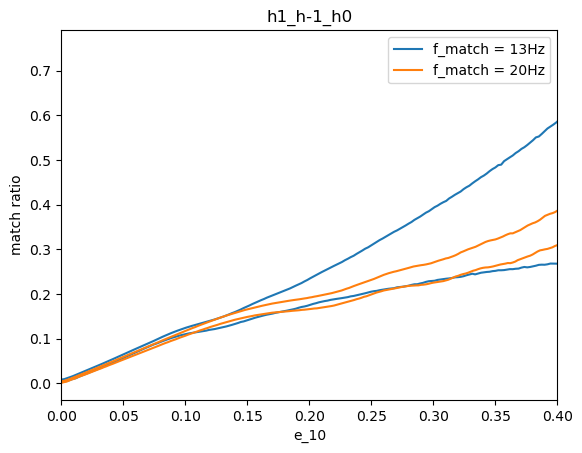

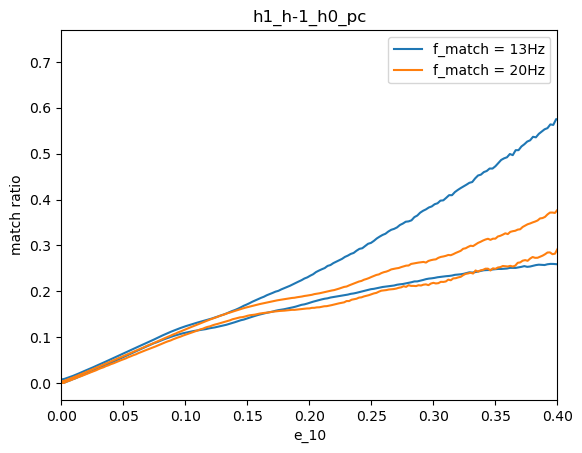

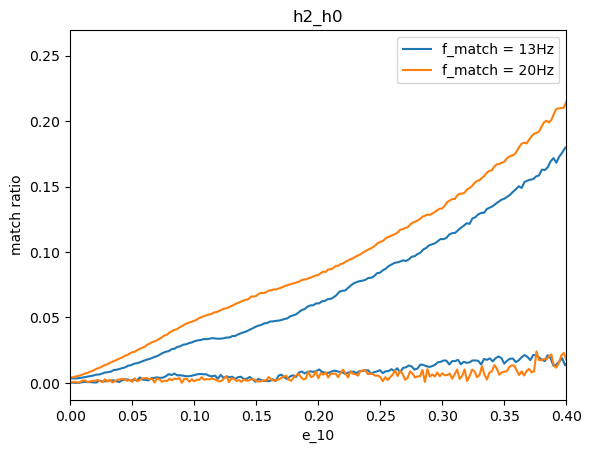

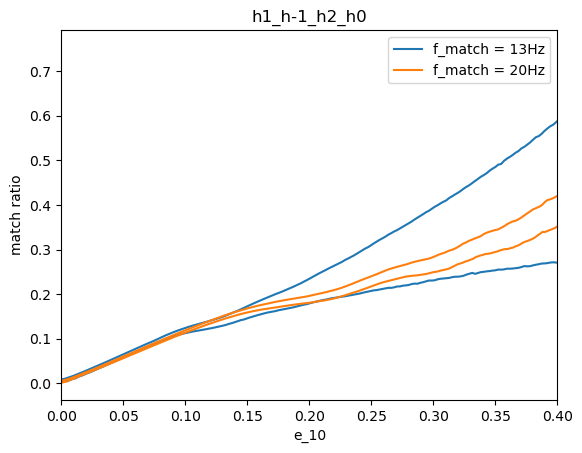

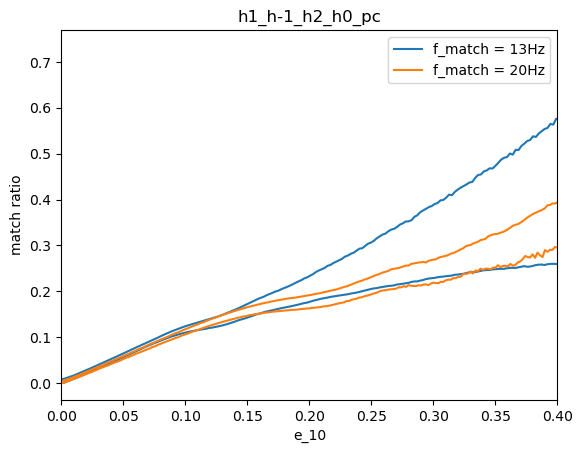

In [4]:
# Make plots
for key in keys:
    if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
        plt.plot(grid_data_old[chirp]['e_vals'], grid_data_old[chirp][f'{key}_max'], c='C0', label='f_match = 13Hz')
        plt.plot(grid_data_old[chirp]['e_vals'], grid_data_old[chirp][f'{key}_min'], c='C0')
        plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp][f'{key}_max'], c='C1', label='f_match = 20Hz')
        plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp][f'{key}_min'], c='C1')            

        # Formatting
        plt.title(key)
        plt.xlabel('e_10')
        if len(key) > 4:
            plt.ylabel('match ratio')
        else:
            plt.ylabel('match')
        plt.legend()
        #plt.ylim(0,)
        plt.xlim(0, 0.4)
        plt.show()

The new h1/h0 doesn't look brilliant by itself, being more 'wiggly' than the old version despite the lower uncertainty. Let's compare both this and (h1, h-1)/h0 on the same plot however.

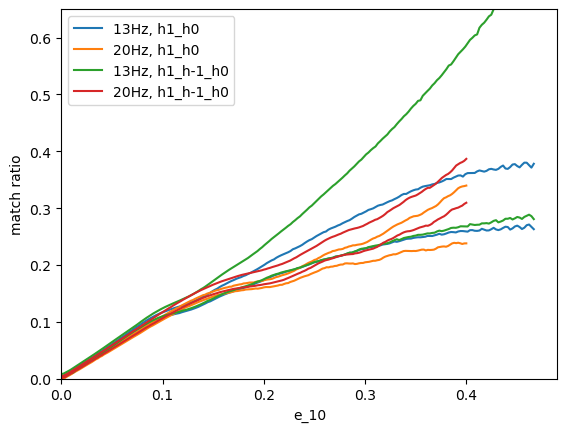

In [9]:
plt.plot(grid_data_old[chirp]['e_vals'], grid_data_old[chirp]['h1_h0_max'], c='C0', label='13Hz, h1_h0')
plt.plot(grid_data_old[chirp]['e_vals'], grid_data_old[chirp]['h1_h0_min'], c='C0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h0_max'], c='C1', label='20Hz, h1_h0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h0_min'], c='C1')
plt.plot(grid_data_old[chirp]['e_vals'], grid_data_old[chirp]['h1_h-1_h0_max'], c='C2', label='13Hz, h1_h-1_h0')
plt.plot(grid_data_old[chirp]['e_vals'], grid_data_old[chirp]['h1_h-1_h0_min'], c='C2')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_max'], c='C3', label='20Hz, h1_h-1_h0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_min'], c='C3')
plt.xlabel('e_10')
plt.ylabel('match ratio')
plt.legend()
plt.ylim(0, 0.65)
plt.xlim(0,)
plt.show()

There are two things here. Firstly, the uncertainty no longer becomes as large at high eccentricities when including h-1, and stays at a very similar level to just h1 (and possible even smaller at the end). Secondly, for f_match=20 we see that the lower bound is increased when including h-1 and the lines therefore seem to be able to increase for longer. Overall therefore both of these things mean that f_match=20Hz and including h-1 are an improvement, and may allow us to go to higher eccentricities than previously!

What about including h2 as well?

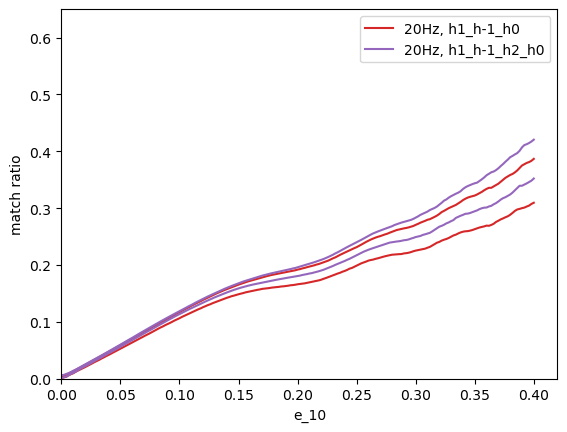

In [11]:
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_max'], c='C3', label='20Hz, h1_h-1_h0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_min'], c='C3')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h2_h0_max'], c='C4', label='20Hz, h1_h-1_h2_h0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h2_h0_min'], c='C4')
plt.xlabel('e_10')
plt.ylabel('match ratio')
plt.legend()
plt.ylim(0, 0.65)
plt.xlim(0,)
plt.show()

This also seems like a sensible improvement!

For completeness, let's try to see what effect phase consistency has on these lines.

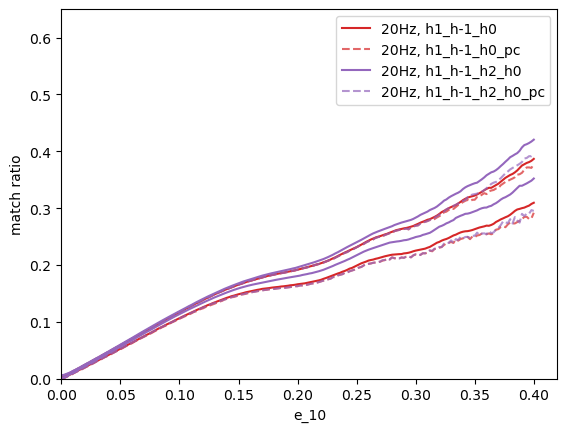

In [15]:
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_max'], c='C3', label='20Hz, h1_h-1_h0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_min'], c='C3')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_pc_max'], c='C3', ls='dashed', alpha=0.7, label='20Hz, h1_h-1_h0_pc')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h0_pc_min'], c='C3', ls='dashed', alpha=0.7)
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h2_h0_max'], c='C4', label='20Hz, h1_h-1_h2_h0')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h2_h0_min'], c='C4')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h2_h0_pc_max'], c='C4', ls='dashed', alpha=0.7, label='20Hz, h1_h-1_h2_h0_pc')
plt.plot(grid_data_new[chirp]['e_vals'], grid_data_new[chirp]['h1_h-1_h2_h0_pc_min'], c='C4', ls='dashed', alpha=0.7)
plt.xlabel('e_10')
plt.ylabel('match ratio')
plt.legend()
plt.ylim(0, 0.65)
plt.xlim(0,)
plt.show()

This does not seem to be an improvement, however this may just be because we are currently working in the zero noise case, and would improve results in the presence of noise.

To check that our f_low of 10 Hz is sufficient, we should create waveforms with f_low=10Hz and lower f_lows to compare the power loss with a low frequency cutoff of 20Hz. At f_low=10Hz, any modes above h2 will start above the low frequency cutoff. We would therefore expect a greater power loss at higher eccentricities where higher modes are more important, as well as at higher chirp masses.

In [61]:
def f_low_power_loss(f_low_1, f_low_2, e_10, chirp, q, f_match, n_TA, return_power_loss=False):

    # Scale eccentricities
    e_1 = shifted_e(f_low_1, 10, e_10)
    e_2 = shifted_e(f_low_2, 10, e_10)

    # Average over true anomaly
    powers_1 = []
    powers_2 = []
    for i in range(n_TA):

        # Create waveforms and psds
        h_1 = gen_wf(f_low_1, e_1, chirp2total(chirp, q), q, 4096, 'TEOBResumS', TA=2*np.pi*i/n_TA)
        h_2 = gen_wf(f_low_2, e_2, chirp2total(chirp, q), q, 4096, 'TEOBResumS', TA=2*np.pi*i/n_TA)
        h_1_f = h_1.real().to_frequencyseries()
        h_2_f = h_2.real().to_frequencyseries()
        psd_1 = gen_psd(h_1_f, f_low_1)
        psd_2 = gen_psd(h_2_f, f_low_2)

        # Calculate power
        h_1_power = sigma(h_1_f, psd_1, low_frequency_cutoff=f_match, high_frequency_cutoff=psd_1.sample_frequencies[-1])
        h_2_power = sigma(h_2_f, psd_2, low_frequency_cutoff=f_match, high_frequency_cutoff=psd_2.sample_frequencies[-1])
        powers_1.append(h_1_power)
        powers_2.append(h_2_power)

    # Plot power at each TA
    if not return_power_loss:
        plt.plot(np.linspace(0, 2*np.pi, n_TA+1), powers_1+[powers_1[0]], label=f'f_low={f_low_1}Hz')
        plt.plot(np.linspace(0, 2*np.pi, n_TA+1), powers_2+[powers_2[0]], label=f'f_low={f_low_2}Hz')
        plt.legend()
        plt.xlabel('TA')
        plt.ylabel('Power')
        plt.xlim(0, 2*np.pi)
        plt.show()

    # Calculate average power
    power_1 = np.sqrt(np.mean(np.array(powers_1)**2))
    power_2 = np.sqrt(np.mean(np.array(powers_2)**2))
    power_loss = (power_2-power_1)/power_2

    # Output results
    if return_power_loss:
        return power_loss
    else:
        print(f'Power at f_low={f_low_1}Hz: {power_1}')
        print(f'Power at f_low={f_low_2}Hz: {power_2}')
        print(f'Power loss: {power_loss*100:.2f}%')

In [62]:
power_losses_10 = []
for i, ecc in enumerate(np.linspace(0, 0.5, 6)):
    power_loss = f_low_power_loss(10, 7, ecc, 10, 2, 20, 16, return_power_loss=True)
    power_losses_10.append(power_loss)
    print(f'\r{i+1} done out of 6', end='')

6 done out of 6

In [63]:
power_losses_24 = []
for i, ecc in enumerate(np.linspace(0, 0.5, 6)):
    power_loss = f_low_power_loss(10, 7, ecc, 24, 2, 20, 16, return_power_loss=True)
    power_losses_24.append(power_loss)
    print(f'\r{i+1} done out of 6', end='')

6 done out of 6

In [64]:
power_losses_50 = []
for i, ecc in enumerate(np.linspace(0, 0.5, 6)):
    power_loss = f_low_power_loss(10, 7, ecc, 50, 2, 20, 16, return_power_loss=True)
    power_losses_50.append(power_loss)
    print(f'\r{i+1} done out of 6', end='')

6 done out of 6

Text(0, 0.5, 'Power loss / %')

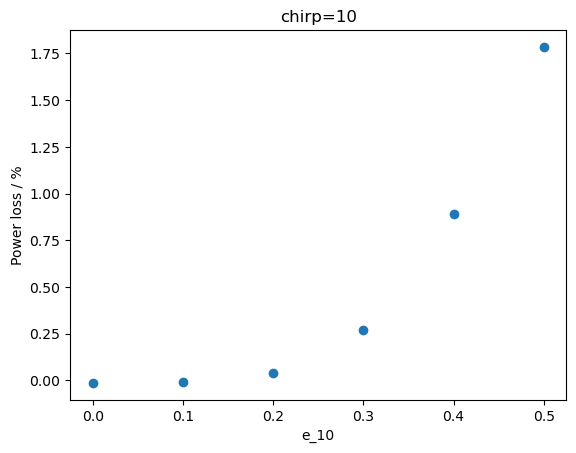

In [65]:
plt.title('chirp=10')
plt.scatter(np.linspace(0, 0.5, 6), np.array(power_losses_10)*100)
plt.xlabel('e_10')
plt.ylabel('Power loss / %')

Text(0, 0.5, 'Power loss / %')

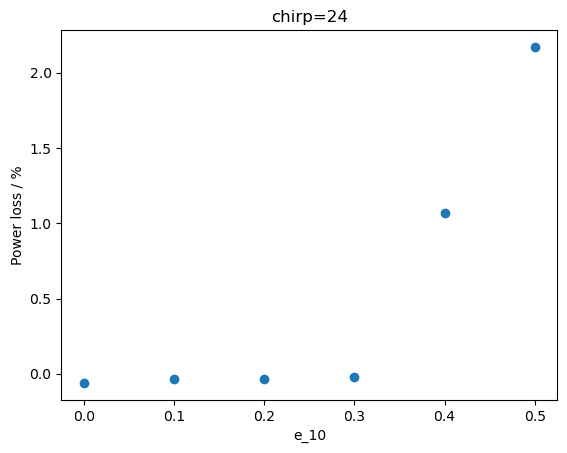

In [66]:
plt.title('chirp=24')
plt.scatter(np.linspace(0, 0.5, 6), np.array(power_losses_24)*100)
plt.xlabel('e_10')
plt.ylabel('Power loss / %')

Text(0, 0.5, 'Power loss / %')

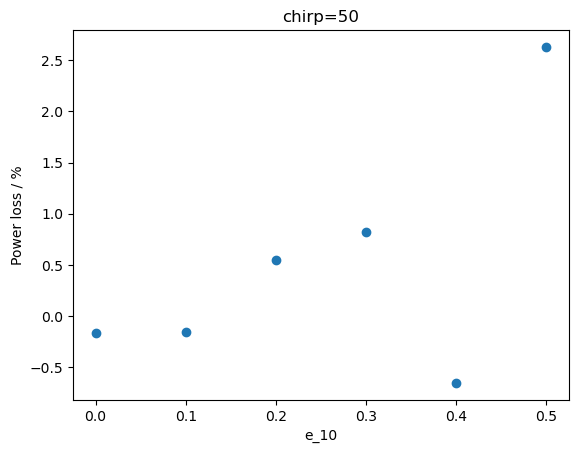

In [67]:
plt.title('chirp=50')
plt.scatter(np.linspace(0, 0.5, 6), np.array(power_losses_50)*100)
plt.xlabel('e_10')
plt.ylabel('Power loss / %')

At e_10=0.4 and above there starts to be a power loss of 1-2%. It is not clear to me however that it is important whether we lose power due to these higher modes, as the highest mode we are matching to teobresums wfs is h2 which should start just under the low frequency cutoff. To test the impact on our results, will calculate match of fiducial harmonics to trial data waveforms of f_low=10Hz and f_low=7Hz.

In [26]:
def harm_power_loss(f_low_1, f_low_2, e_10, zero_ecc_chirp, q, f_match, n_TA, return_matches=False):

    # Scale eccentricities
    e_1 = shifted_e(f_low_1, 10, e_10)
    e_2 = shifted_e(f_low_2, 10, e_10)

    # Calculate degeneracy line
    scaling_norms = [10, 0.03]
    fid_e = zero_ecc_chirp**(5/6)*scaling_norms[1]/(scaling_norms[0]**(5/6))
    fid_chirp, chirp = chirp_degeneracy_line(zero_ecc_chirp, [fid_e, e_10], 4096, f_low=10, q=q, f_match=f_match)

    # Generate harmonics
    all_wfs = list(get_h([1,1,1,1], 10, fid_e, chirp2total(fid_chirp, q), q, 4096))
    fid_wfs = all_wfs[1:5]

    # Average over true anomaly
    matches_1 = []
    matches_2 = []
    for i in range(n_TA):

        # Create waveforms
        h_1 = gen_wf(f_low_1, e_1, chirp2total(chirp, q), q, 4096, 'TEOBResumS', TA=2*np.pi*i/n_TA)
        h_2 = gen_wf(f_low_2, e_2, chirp2total(chirp, q), q, 4096, 'TEOBResumS', TA=2*np.pi*i/n_TA)

        # Calculate matches
        h_1_matches = match_hn(fid_wfs, h_1, 10, f_match=f_match)
        h_2_matches = match_hn(fid_wfs, h_2, 10, f_match=f_match)
        matches_1.append(np.abs(h_1_matches))
        matches_2.append(np.abs(h_2_matches))

    # Plot power at each TA
    if not return_matches:
        for i, (match_line_1, match_line_2, wf) in enumerate(zip(np.array(matches_1).T, np.array(matches_2).T, ['h0', 'h1', 'h-1', 'h2'])):
            plt.plot(np.linspace(0, 2*np.pi, n_TA+1), list(match_line_1)+[match_line_1[0]], c=f'C{i}', label=f'{wf}, {f_low_1}Hz')
            plt.plot(np.linspace(0, 2*np.pi, n_TA+1), list(match_line_2)+[match_line_2[0]], c=f'C{i}', ls='dotted', alpha=0.7, label=f'{wf}, {f_low_2}Hz')
        plt.legend()
        plt.xlabel('TA')
        plt.ylabel('Match')
        plt.xlim(0, 2*np.pi)
        plt.show()

    # Calculate average power
    match_1 = np.sqrt(np.mean(np.array(matches_1)**2, axis=0))
    match_2 = np.sqrt(np.mean(np.array(matches_2)**2, axis=0))
    match_loss = (match_2-match_1)/match_2

    # Output results
    if return_matches:
        return match_1, match_2
    else:
        print(f'Matches at f_low={f_low_1}Hz: {match_1}')
        print(f'Matches at f_low={f_low_2}Hz: {match_2}')
        print(f'Match losses: {match_loss*100}%')

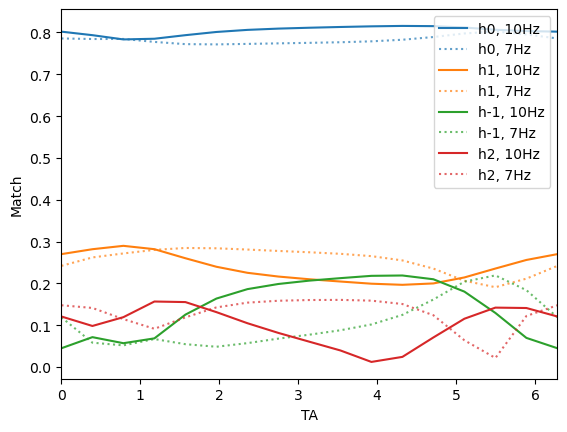

Matches at f_low=10Hz: [0.80422444 0.23847863 0.16075103 0.10799837]
Matches at f_low=7Hz: [0.78259742 0.25745691 0.11917171 0.13250232]
Match losses: [ -2.76349214   7.37143743 -34.8902586   18.49321817]%


In [28]:
harm_power_loss(10, 7, 0.4, 24, 2, 20, 16)

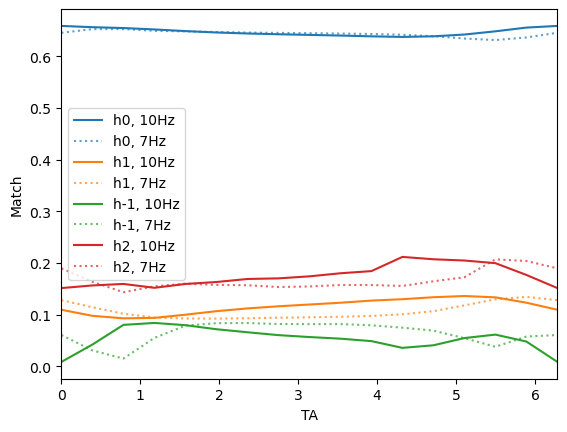

Matches at f_low=10Hz: [0.64646608 0.1169023  0.05889684 0.17738738]
Matches at f_low=7Hz: [0.64369633 0.10656997 0.06744868 0.16678458]
Match losses: [-0.43028895 -9.69534815 12.67903314 -6.3571831 ]%


In [31]:
harm_power_loss(10, 7, 0.4, 10, 2, 20, 16)

In [60]:
h = gen_wf(5, 0.15, chirp2total(10, 2), 2, 4096, 'TEOBResumS')
h_f = h.real()[:8*4096].to_frequencyseries()

(0.0, 40.0)

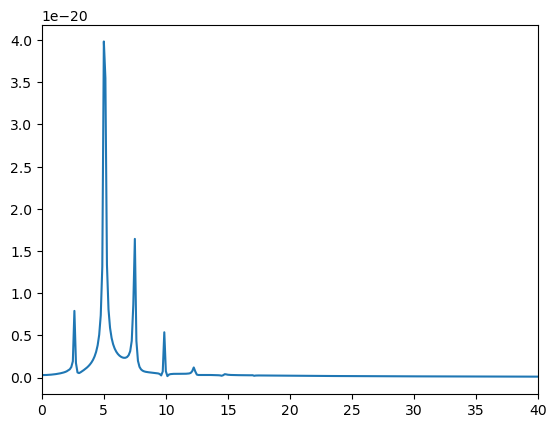

In [61]:
plt.plot(h_f.sample_frequencies, np.abs(h_f))
plt.xlim(0,40)